In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np

# Define paths to your image folders
cases_path = "/content/drive/MyDrive/dataset/feature_map/cases"
controls_path = "/content/drive/MyDrive/dataset/feature_map/controls"

# Function to load and preprocess images from a folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))  # Resize images to a consistent size
            images.append(img)
    return np.array(images)

# Image dimensions
img_width, img_height = 50, 50  # Adjust dimensions as needed

# Load images from folders
cases_images = load_images_from_folder(cases_path)
controls_images = load_images_from_folder(controls_path)

# Create labels (1 for cases, 0 for controls)
cases_labels = np.ones(len(cases_images))
controls_labels = np.zeros(len(controls_images))

# Concatenate images and labels
X = np.concatenate((cases_images, controls_images), axis=0)
y = np.concatenate((cases_labels, controls_labels), axis=0)

# Shuffle data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Normalize image data
X = X / 255.0

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the image dimensions
img_width, img_height = 71, 71

# Define the Xception-based model
def xception_net():
    # Load the Xception model without the top layer (fully connected layer)
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)

    # Define the complete model
    model = Model(inputs=base_model.input, outputs=output)

    # Freeze the base model's layers to prevent them from being updated during the initial training phase
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Number of folds for cross-validation
num_folds = 5

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
conf_matrices = []

# Print model summary only once
model = xception_net()
print("Model Summary:")
model.summary()

# Loop through each fold
for fold, (train_indices, test_indices) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split data into train and test sets for this fold
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # Split train data into train and validation sets for this fold
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Resize images to the expected shape
    X_train_fold = tf.image.resize(X_train_fold, [img_height, img_width])
    X_val_fold = tf.image.resize(X_val_fold, [img_height, img_width])
    X_test = tf.image.resize(X_test, [img_height, img_width])

    # Create and compile the model for this fold
    model = xception_net()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    # Train the model with early stopping
    history = model.fit(X_train_fold, y_train_fold, batch_size=32, epochs=100, verbose=1,
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    # Unfreeze some layers in the base model and fine-tune the model
    for layer in model.layers[-30:]:
        layer.trainable = True

    # Recompile the model with a lower learning rate for fine-tuning
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Fine-tune the model
    history_fine = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=1,
                             validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    # Evaluate the model on training set
    train_loss, train_accuracy = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Evaluate the model on validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the model
    model.save(f'model_fold_XN_{fold + 1}.h5')

    # Save metrics for this fold
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Evaluate the model on test set
    y_pred_test = np.argmax(model.predict(X_test), axis=-1)

    # Generate confusion matrix for test set
    conf_matrix_test = confusion_matrix(y_test, y_pred_test)
    conf_matrices.append(conf_matrix_test)

    # Print classification report for test set
    print(f"Classification Report for Fold {fold + 1}:")
    print(classification_report(y_test, y_pred_test))

# Print average metrics for each fold
for fold in range(num_folds):
    print(f"\nMetrics for Fold {fold + 1}:")
    print(f"Average Training Loss: {train_losses[fold]:.4f}, Average Training Accuracy: {train_accuracies[fold]:.4f}")
    print(f"Average Validation Loss: {val_losses[fold]:.4f}, Average Validation Accuracy: {val_accuracies[fold]:.4f}")

# Print confusion matrices for each fold
for fold, conf_matrix in enumerate(conf_matrices):
    print(f"\nConfusion Matrix for Fold {fold + 1}:")
    print(conf_matrix)


Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 71, 71, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 35, 35, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 35, 35, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 35, 35, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 33, 33, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 33, 33, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 33, 33, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 33, 33, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 33, 33, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 33, 33, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 17, 17, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 17, 17, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Fold 1/5
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 859ms/step - accuracy: 0.6716 - loss: 0.5872 - val_accuracy: 0.9032 - val_loss: 0.2858
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8044 - loss: 0.4384 - val_accuracy: 0.9032 - val_loss: 0.3020
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7767 - loss: 0.4377 - val_accuracy: 0.8548 - val_loss: 0.3087
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8496 - loss: 0.3198 - val_accuracy: 0.8226 - val_loss: 0.3254
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8936 - loss: 0.2735 - val_accuracy: 0.9355 - val_loss: 0.2554
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8789 - loss: 0.2456 - val_accuracy: 0.8710 - val_loss: 0.2608
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9009 - loss: 0.2196 - val_accuracy: 0.8387 - val_loss: 0.3281
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8910 - loss: 0.2415 - val_accuracy: 0.9032 

Training Loss: 0.2868, Training Accuracy: 0.8745
Validation Loss: 0.3870, Validation Accuracy: 0.8387
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Classification Report for Fold 1:
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.81        35
         1.0       0.85      0.81      0.83        43

    accuracy                           0.82        78
   macro avg       0.82      0.82      0.82        78
weighted avg       0.82      0.82      0.82        78

Fold 2/5
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5108 - loss: 1.0050 - val_accuracy: 0.8387 - val_loss: 0.4021
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.7724 - loss: 0.4421 - val_accuracy: 0.8871 - val_loss: 0.3491
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8697 - loss: 0.3164 - val_accuracy: 0.8871 - val_loss: 0.3313
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8466 - loss: 0.3219 - val_accuracy: 0.9355 - val_l

Training Loss: 0.3260, Training Accuracy: 0.8826
Validation Loss: 0.3259, Validation Accuracy: 0.9194
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 945ms/step
Classification Report for Fold 2:
              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77        35
         1.0       0.82      0.77      0.80        43

    accuracy                           0.78        78
   macro avg       0.78      0.78      0.78        78
weighted avg       0.79      0.78      0.78        78

Fold 3/5
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6634 - loss: 0.7148 - val_accuracy: 0.8226 - val_loss: 0.3626
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.8348 - loss: 0.3485 - val_accuracy: 0.8548 - val_loss: 0.3366
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8986 - loss: 0.2540 - val_accuracy: 0.8710 - val_loss: 0.3358
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8806 - loss: 0.2324 - val_accuracy: 0.8548 - val

Validation Loss: 0.5077, Validation Accuracy: 0.7903


1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Classification Report for Fold 3:
              precision    recall  f1-score   support

         0.0       0.71      0.86      0.78        35
         1.0       0.86      0.71      0.78        42

    accuracy                           0.78        77
   macro avg       0.79      0.79      0.78        77
weighted avg       0.79      0.78      0.78        77

Fold 4/5
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5208 - loss: 0.7707 - val_accuracy: 0.7258 - val_loss: 0.7215
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8118 - loss: 0.5901 - val_accuracy: 0.8871 - val_loss: 0.3259
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8687 - loss: 0.3331 - val_accuracy: 0.8548 - val_loss: 0.3069
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8404 - loss: 0.3362 - val_accuracy: 0.8387 - val_loss: 0.3186
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8931 - loss: 0.2602 - val_a

Training Loss: 0.2770, Training Accuracy: 0.8831
Validation Loss: 0.4030, Validation Accuracy: 0.8548
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 985ms/step
Classification Report for Fold 4:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83        35
         1.0       0.86      0.86      0.86        42

    accuracy                           0.84        77
   macro avg       0.84      0.84      0.84        77
weighted avg       0.84      0.84      0.84        77

Fold 5/5
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5636 - loss: 0.7871 - val_accuracy: 0.7903 - val_loss: 0.4987
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8183 - loss: 0.3941 - val_accuracy: 0.7903 - val_loss: 0.4017
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8518 - loss: 0.3362 - val_accuracy: 0.7742 - val_loss: 0.4251
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8915 - loss: 0.2914 - val_accuracy: 0.8226 - va

Training Loss: 0.2553, Training Accuracy: 0.8790
Validation Loss: 0.4350, Validation Accuracy: 0.7903
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 993ms/step
Classification Report for Fold 5:
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84        34
         1.0       0.92      0.79      0.85        43

    accuracy                           0.84        77
   macro avg       0.85      0.85      0.84        77
weighted avg       0.86      0.84      0.84        77


Metrics for Fold 1:
Average Training Loss: 0.2868, Average Training Accuracy: 0.8745
Average Validation Loss: 0.3870, Average Validation Accuracy: 0.8387

Metrics for Fold 2:
Average Training Loss: 0.3260, Average Training Accuracy: 0.8826
Average Validation Loss: 0.3259, Average Validation Accuracy: 0.9194

Metrics for Fold 3:
Average Training Loss: 0.2899, Average Training Accuracy: 0.8790
Average Validation Loss: 0.5077, Average Validation Accuracy: 0.7903

Metrics for Fold 4:
Average Trai

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set image dimensions
img_width, img_height = 71, 71

# Define paths to cases and controls folders
cases_path = '/content/drive/MyDrive/dataset/predicted_mask_final/cases'
controls_path = '/content/drive/MyDrive/dataset/predicted_mask_final/controls'

# Load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

cases_images, cases_labels = load_images_from_folder(cases_path, 1)
controls_images, controls_labels = load_images_from_folder(controls_path, 0)

# Combine cases and controls
X = np.concatenate((cases_images, controls_images), axis=0)
y = np.concatenate((cases_labels, controls_labels), axis=0)

# Normalize images
X = X / 255.0

# Split the dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Load the Xception model with pre-trained weights, excluding the top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model's layers to prevent them from being updated during the initial training phase
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Perform Leave-One-Out Cross-Validation (LOOCV) on the training set
loo = LeaveOneOut()
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

fold_no = 1
for train_index, val_index in loo.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)

    # Store metrics
    train_loss_list.append(history.history['loss'][-1])
    train_accuracy_list.append(history.history['accuracy'][-1])
    val_loss_list.append(history.history['val_loss'][-1])
    val_accuracy_list.append(history.history['val_accuracy'][-1])

    print(f'Fold {fold_no} - Train Loss: {history.history["loss"][-1]:.4f} - Train Accuracy: {history.history["accuracy"][-1]:.4f} - Val Loss: {history.history["val_loss"][-1]:.4f} - Val Accuracy: {history.history["val_accuracy"][-1]:.4f}')
    fold_no += 1

# Compute average metrics
avg_train_loss = np.mean(train_loss_list)
avg_train_accuracy = np.mean(train_accuracy_list)
avg_val_loss = np.mean(val_loss_list)
avg_val_accuracy = np.mean(val_accuracy_list)

print(f"\nAverage Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

# Unfreeze some layers in the base model and fine-tune the model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Print test classification report and confusion matrix
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_classes))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_classes))

# Save the model
model.save('xception_finetuned_model_3.h5')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 71, 71, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 35, 35, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 35, 35, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 35, 35, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 33, 33, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 33, 33, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 33, 33, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 33, 33, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 33, 33, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 33, 33, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 17, 17, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 17, 17, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Fold 1 - Train Loss: 0.0063 - Train Accuracy: 1.0000 - Val Loss: 0.0003 - Val Accuracy: 1.0000
Fold 2 - Train Loss: 0.0051 - Train Accuracy: 1.0000 - Val Loss: 0.0316 - Val Accuracy: 1.0000


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set image dimensions
img_width, img_height = 71, 71

# Define paths to cases and controls folders
cases_path = '/content/drive/MyDrive/dataset/predicted_mask_final/cases'
controls_path = '/content/drive/MyDrive/dataset/predicted_mask_final/controls'

# Load images and labels
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

cases_images, cases_labels = load_images_from_folder(cases_path, 1)
controls_images, controls_labels = load_images_from_folder(controls_path, 0)

# Combine cases and controls
X = np.concatenate((cases_images, controls_images), axis=0)
y = np.concatenate((cases_labels, controls_labels), axis=0)

# Normalize images
X = X / 255.0

# Split the dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Load the Xception model with pre-trained weights, excluding the top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model's layers to prevent them from being updated during the initial training phase
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Initialize lists to collect metrics
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Collect metrics from the history object
train_loss_list.extend(history.history['loss'])
train_accuracy_list.extend(history.history['accuracy'])
val_loss_list.extend(history.history['val_loss'])
val_accuracy_list.extend(history.history['val_accuracy'])

# Unfreeze some layers in the base model and fine-tune the model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Collect metrics from the fine-tuning history object
train_loss_list.extend(history_fine.history['loss'])
train_accuracy_list.extend(history_fine.history['accuracy'])
val_loss_list.extend(history_fine.history['val_loss'])
val_accuracy_list.extend(history_fine.history['val_accuracy'])

# Compute average metrics
avg_train_loss = np.mean(train_loss_list)
avg_train_accuracy = np.mean(train_accuracy_list)
avg_val_loss = np.mean(val_loss_list)
avg_val_accuracy = np.mean(val_accuracy_list)

print(f"\nAverage Train Loss: {avg_train_loss:.4f}")
print(f"Average Train Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Print test classification report and confusion matrix
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_classes))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_classes))

# Save the model
model.save('xception_finetuned_model_3.h5')


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 71, 71, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 35, 35, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 35, 35, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 35, 35, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 33, 33, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 33, 33, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 33, 33, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 33, 33, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 33, 33, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 33, 33, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 17, 17, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 17, 17, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,124,010 (80.58 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6725 - loss: 0.6044 - val_accuracy: 0.8226 - val_loss: 0.4161
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8169 - loss: 0.3778 - val_accuracy: 0.8226 - val_loss: 0.4016
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 883ms/step - accuracy: 0.8455 - loss: 0.3069 - val_accuracy: 0.8387 - val_loss: 0.3181
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 986ms/step - accuracy: 0.9170 - loss: 0.2310 - val_accuracy: 0.8548 - val_loss: 0.3074
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 807ms/step - accuracy: 0.9370 - loss: 0.1927 - val_accuracy: 0.9194 - val_loss: 0.2566
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9465 - loss: 0.1685 - val_accuracy: 0.9032 - val_loss: 0.2680
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 816ms/step - accuracy: 0.9402 - loss: 0.1677 - val_accuracy: 0.9032 - val_loss: 0.2520
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9420 - loss: 0.1451 - val_accuracy: 0.9355 - val_loss: 0.2358
Epo


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        35
           1       0.85      0.81      0.83        43

    accuracy                           0.82        78
   macro avg       0.82      0.82      0.82        78
weighted avg       0.82      0.82      0.82        78


Confusion Matrix (Test):
[[29  6]
 [ 8 35]]


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/xception results/xception_finetuned_model_2.h5')  # Change the filename as per your saved model

# Define the image dimensions as per the model's input shape
img_width, img_height = 71, 71

# Define a function to normalize and predict the class of a new image
def predict_class(image_path, model):
    # Read the image
    img = cv2.imread(image_path)

    # Resize the image to match the input shape of the model
    img_resized = cv2.resize(img, (img_width, img_height))

    # Convert the image from BGR to RGB (if needed, depending on your model)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Normalize the image
    img_normalized = img_rgb / 255.0  # Normalize pixel values to range [0, 1]

    # Preprocess the image (optional, depending on how the model was trained)
    # img_preprocessed = preprocess_input(img_normalized)  # Uncomment if you used a specific preprocessing method

    # Perform prediction
    probabilities = model.predict(np.expand_dims(img_normalized, axis=0))

    # Decode the prediction
    if probabilities[0][0] > probabilities[0][1]:
        return "Normal", probabilities[0][0]
    else:
        return "Diseased", probabilities[0][1]

# Path to the new image
image_path = '/content/drive/MyDrive/dataset/feature_map/cases/P1335401_OD.png'

# Predict the class of the new image
predicted_class, probability = predict_class(image_path, loaded_model)

# Output the prediction
print(f"The image is classified as {predicted_class} with probability {probability}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The image is classified as Diseased with probability 0.6566349864006042


## grad cam

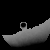

In [ ]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

## The local path to our target image

img_path= "/content/drive/MyDrive/dataset/multiplied_images/cases/N255969_OS.png"

display(Image(img_path))
def get_img_array(img_path, size):
    ## `img` is a PIL image
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted of image: [('n02951585', 'can_opener', 5.656045)]


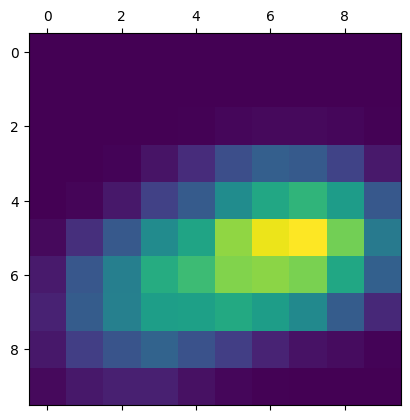

In [ ]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

## Making the model with imagenet dataset
model = model_builder(weights="imagenet")

## Remove last layer's softmax(transfer learning)
model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted of image:", decode_predictions(preds, top=1)[0])

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

## visulization of heatmap
plt.matshow(heatmap)
plt.show()

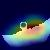

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = keras.utils.array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)

    ## Displaying Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
model_path = '/content/drive/MyDrive/xception results/xception_finetuned_model.h5'
model = keras.models.load_model(model_path)


In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 71, 71, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 35, 35, 32)     │            864 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 35, 35, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 35, 35, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 33, 33, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 33, 33, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 33, 33, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 33, 33, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 33, 33, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 33, 33, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 17, 17, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 17, 17, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,124,012 (80.58 MB)

 Trainable params: 9,202,882 (35.11 MB)

 Non-trainable params: 11,921,128 (45.48 MB)

 Optimizer params: 2 (12.00 B)